In [1]:
import pandas as pd
import numpy as np
import re
import gensim
from gensim import corpora   #to make dictionary
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize  #to convert string to words
from nltk.corpus import stopwords  #to remove stopwords
from nltk.stem import WordNetLemmatizer #to lemmatize words
from gensim.models import Word2Vec #to convert text to vector
from sklearn.feature_extraction.text import TfidfVectorizer #to convert text to vector
from sklearn.preprocessing import LabelEncoder #to convert categories to numeric values
from sklearn.feature_extraction.text import CountVectorizer #to convert text to vectors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split #to divide the data into training and testing sets
from sklearn.preprocessing import StandardScaler #to fit values into model
from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anupa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Collect a dataset of labeled news articles (sports, politics, technology etc).

In [3]:
df=pd.read_csv("data_news - data_news.csv")

In [4]:
df.head()

category                                           headline  \
0  WELLNESS              143 Miles in 35 Days: Lessons Learned   
1  WELLNESS       Talking to Yourself: Crazy or Crazy Helpful?   
2  WELLNESS  Crenezumab: Trial Will Gauge Whether Alzheimer...   
3  WELLNESS                     Oh, What a Difference She Made   
4  WELLNESS                                   Green Superfoods   

                                               links  \
0  https://www.huffingtonpost.com/entry/running-l...   
1  https://www.huffingtonpost.com/entry/talking-t...   
2  https://www.huffingtonpost.com/entry/crenezuma...   
3  https://www.huffingtonpost.com/entry/meaningfu...   
4  https://www.huffingtonpost.com/entry/green-sup...   

                                   short_description  \
0  Resting is part of training. I've confirmed wh...   
1  Think of talking to yourself as a tool to coac...   
2  The clock is ticking for the United States to ...   
3  If you want to be busy, keep trying to be perf...   
4  First, the bad news: Soda bread, corned beef a...   

                             keywords  
0                     running-lessons  
1           talking-to-yourself-crazy  
2  crenezumab-alzheimers-disease-drug  
3                     meaningful-life  
4                    green-superfoods

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  50000 non-null  object
 4   keywords           47332 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


In [6]:
df.describe()

category        headline  \
count      50000           50000   
unique        10           45577   
top     WELLNESS  Sunday Roundup   
freq        5000              22   

                                                    links  \
count                                               50000   
unique                                              45745   
top     https://www.huffingtonpost.com/entry/bryce-har...   
freq                                                    8   

                                        short_description keywords  
count                                               50000    47332  
unique                                              45743    41558  
top     Along with his fists, the star Nationals outfi...     post  
freq                                                    8       85

Handle missing data, if any, and ensure the text is ready for feature extraction.


In [8]:
print(df.isnull().sum())

category                0
headline                0
links                   0
short_description       0
keywords             2668
dtype: int64


In [9]:
df['keywords'] = df['keywords'].fillna('Unknown')

In [10]:
print("Duplicate rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

Duplicate rows: 4251


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45749 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           45749 non-null  object
 1   headline           45749 non-null  object
 2   links              45749 non-null  object
 3   short_description  45749 non-null  object
 4   keywords           45749 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [12]:
df['category'].value_counts()

category
WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          3091
SPORTS            2658
Name: count, dtype: int64

Clean and preprocess the text data.

In [14]:
def preprocess_text(text):
    # 1. Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # 2. Tokenize
    tokens = word_tokenize(text.lower())

    # 3. Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 4. Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return lemmatized_tokens

In [15]:
def apply_preprocessing(df, columns):
    for col in columns:
        df[col] = df[col].apply(preprocess_text)
    return df

In [16]:
columns=['headline','links','short_description','keywords']
apply_preprocessing(df,columns)

category                                           headline  \
0      WELLNESS              [143, mile, 35, day, lesson, learned]   
1      WELLNESS                   [talking, crazy, crazy, helpful]   
2      WELLNESS  [crenezumab, trial, gauge, whether, alzheimers...   
3      WELLNESS                             [oh, difference, made]   
4      WELLNESS                                [green, superfoods]   
...         ...                                                ...   
49988    SPORTS     [gregg, popovich, wish, gut, dye, hair, blond]   
49991    SPORTS   [rafal, lipinski, nail, sick, complicated, dunk]   
49995    SPORTS  [baseball, team, learned, there, wrong, way, c...   
49996    SPORTS  [young, spur, fan, dabbed, 38, time, single, p...   
49999    SPORTS  [simone, bile, isnt, next, anyone, shes, first...   

                                                   links  \
0      [httpswwwhuffingtonpostcomentryrunninglessonsu...   
1      [httpswwwhuffingtonpostcomentrytalkingtoyourse...   
2      [httpswwwhuffingtonpostcomentrycrenezumabalzhe...   
3      [httpswwwhuffingtonpostcomentrymeaningfullifeu...   
4      [httpswwwhuffingtonpostcomentrygreensuperfoods...   
...                                                  ...   
49988  [httpswwwhuffingtonpostcomentrygreggpopovichge...   
49991  [httpswwwhuffingtonpostcomentryrafallipinskina...   
49995  [httpswwwhuffingtonpostcomentrysanjosegiantsja...   
49996  [httpswwwhuffingtonpostcomentrydabkidsanantoni...   
49999  [httpswwwhuffingtonpostcomentrythefirstsimoneb...   

                                       short_description  \
0      [resting, part, training, ive, confirmed, sort...   
1      [think, talking, tool, coach, challenge, narra...   
2      [clock, ticking, united, state, find, cure, te...   
3      [want, busy, keep, trying, perfect, want, happ...   
4      [first, bad, news, soda, bread, corned, beef, ...   
...                                                  ...   
49988  [monday, event, beg, question, would, blond, p...   
49991                              [plenty, air, plenty]   
49995  [many, fan, pissed, seeing, minor, league, tea...   
49996         [never, change, young, man, never, change]   
49999                                  [gymnast, league]   

                                      keywords  
0                             [runninglessons]  
1                     [talkingtoyourselfcrazy]  
2            [crenezumabalzheimersdiseasedrug]  
3                             [meaningfullife]  
4                            [greensuperfoods]  
...                                        ...  
49988       [greggpopovichgeorgehillhairblond]  
49991  [rafallipinskinailssickcomplicateddunk]  
49995     [sanjosegiantsjapaneseheritagenight]  
49996                  [dabkidsanantoniospurs]  
49999                    [thefirstsimonebiles]  

[45749 rows x 5 columns]

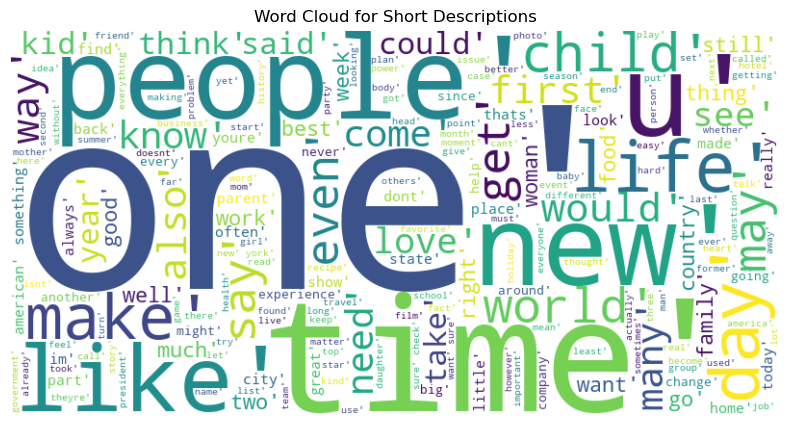

In [17]:
text = " ".join(map(str,df['short_description'].tolist()))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Short Descriptions")
plt.show()

In [18]:
# converting categorical column s to numbers
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['category']=encoder.fit_transform(df['category'])
df['category']

0        8
1        8
2        8
3        8
4        8
        ..
49988    5
49991    5
49995    5
49996    5
49999    5
Name: category, Length: 45749, dtype: int32

Use methods like TF-IDF, word embeddings (e.g., Word2Vec, GloVe), or
bag-of-words to convert text data into numerical features.

In [20]:
tfidf = TfidfVectorizer()

# Convert all to string type
df['headline'] = df['headline'].astype(str)
df['short_description'] = df['short_description'].astype(str)
df['keywords'] = df['keywords'].astype(str) 

x_text=tfidf.fit_transform(df['headline']+" "+df['short_description']+" "+df['keywords'])
                           
x=x_text
y=df['category']

In [21]:
#vectorization using BoW to apply the naive bayes model
vectorizer=CountVectorizer()
bow = CountVectorizer()
X_bow = bow.fit_transform(df['headline']+" "+df['short_description']+" "+df['keywords'])

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("Train size:", x_train.shape)
print("Test size:", x_test.shape)

Train size: (36599, 93776)
Test size: (9150, 93776)


Perform exploratory data analysis (EDA) to understand the distribution of different
categories

In [24]:
# Number of records per category
category_counts = df['category'].value_counts()

print("Total unique categories:", df['category'].nunique())
print("\nTop categories by frequency:\n")
print(category_counts.head(10))

Total unique categories: 10

Top categories by frequency:

category
8    5000
4    5000
1    5000
7    5000
6    5000
3    5000
2    5000
9    5000
0    3091
5    2658
Name: count, dtype: int64


C:\Users\anupa\AppData\Local\Temp\ipykernel_12116\4139391669.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


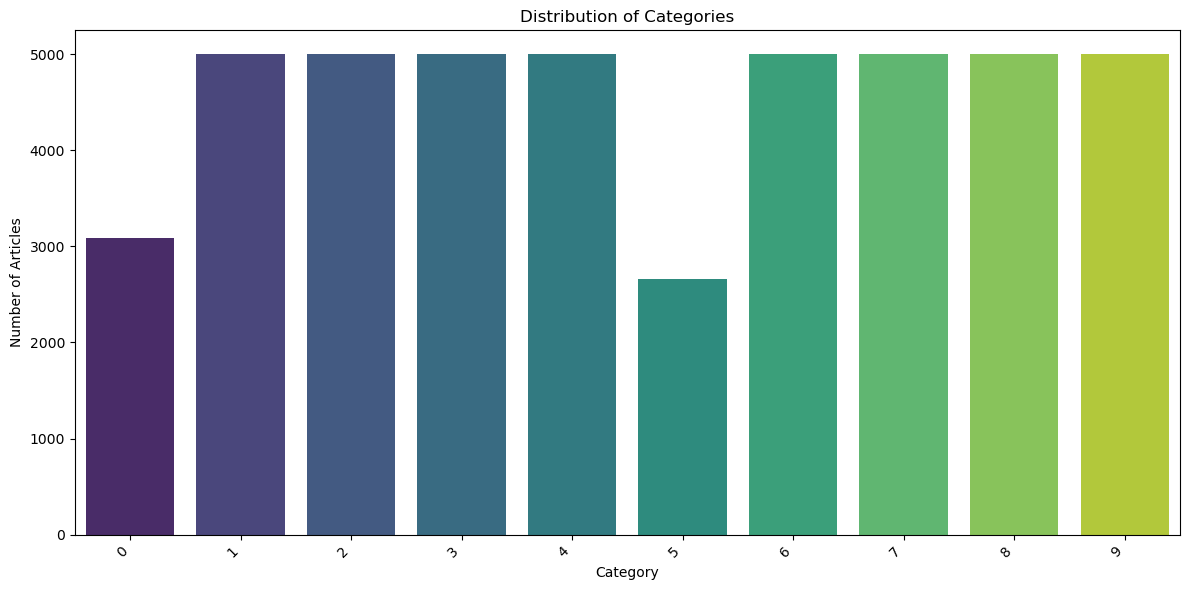

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")

plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

Build classification models using algorithms like Logistic Regression, Naive Bayes,
Support Vector Machines (SVM).

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [28]:
scaler = StandardScaler(with_mean=False)

X_train = scaler.fit_transform(x_train)  
X_test = scaler.transform(x_test)

In [29]:
model1_lr = LogisticRegression()
model1_lr.fit(X_train, y_train)
y_pred_lr = model1_lr.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.72      0.58      0.64       631
           1       0.79      0.77      0.78       990
           2       0.84      0.85      0.85       994
           3       0.69      0.76      0.73       973
           4       0.76      0.73      0.74      1001
           5       0.87      0.73      0.79       533
           6       0.85      0.83      0.84      1027
           7       0.78      0.77      0.77       983
           8       0.67      0.77      0.72      1024
           9       0.78      0.80      0.79       994

    accuracy                           0.77      9150
   macro avg       0.77      0.76      0.76      9150
weighted avg       0.77      0.77      0.77      9150



In [30]:
#doing the splitting again with different variable names because Naive Bayes cannot handle negative values

x_train2, x_test2, y_train2, y_test2 = train_test_split(X_bow, y, test_size=0.2, random_state=42)
print("Train size:", x_train2.shape)
print("Test size:", x_test2.shape)


Train size: (36599, 93776)
Test size: (9150, 93776)


In [31]:
scaler = StandardScaler(with_mean=False)

X_train2 = scaler.fit_transform(x_train2)  
X_test2 = scaler.transform(x_test2)

model2_nb = MultinomialNB()
model2_nb.fit(X_train2, y_train2)
y_pred_nb = model2_nb.predict(X_test2)

print("Naive Bayes:\n", classification_report(y_test2, y_pred_nb))

Naive Bayes:
               precision    recall  f1-score   support

           0       0.44      0.48      0.46       631
           1       0.64      0.61      0.63       990
           2       0.77      0.66      0.71       994
           3       0.47      0.50      0.49       973
           4       0.61      0.59      0.60      1001
           5       0.65      0.62      0.63       533
           6       0.68      0.68      0.68      1027
           7       0.59      0.57      0.58       983
           8       0.54      0.62      0.58      1024
           9       0.67      0.67      0.67       994

    accuracy                           0.61      9150
   macro avg       0.61      0.60      0.60      9150
weighted avg       0.61      0.61      0.61      9150



In [32]:
model3_svm = LinearSVC()
model3_svm.fit(X_train, y_train)
y_pred_svm = model3_svm.predict(X_test)

print("SVM:\n", classification_report(y_test, y_pred_svm))

SVM:
               precision    recall  f1-score   support

           0       0.66      0.58      0.62       631
           1       0.79      0.73      0.76       990
           2       0.81      0.83      0.82       994
           3       0.66      0.76      0.71       973
           4       0.77      0.70      0.73      1001
           5       0.84      0.74      0.78       533
           6       0.83      0.82      0.83      1027
           7       0.75      0.72      0.74       983
           8       0.65      0.76      0.70      1024
           9       0.76      0.78      0.77       994

    accuracy                           0.75      9150
   macro avg       0.75      0.74      0.74      9150
weighted avg       0.75      0.75      0.75      9150



In [75]:
model4_rf = RandomForestClassifier(n_estimators=100,max_depth=20,max_features='sqrt',n_jobs=-1,random_state=42)
model4_rf.fit(X_train, y_train)
y_pred_rf = model4_rf.predict(X_test)

print("Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest:
               precision    recall  f1-score   support

           0       0.83      0.14      0.24       631
           1       0.50      0.66      0.57       990
           2       0.76      0.81      0.79       994
           3       0.67      0.75      0.70       973
           4       0.68      0.66      0.67      1001
           5       0.90      0.21      0.34       533
           6       0.69      0.83      0.76      1027
           7       0.67      0.67      0.67       983
           8       0.62      0.68      0.65      1024
           9       0.65      0.76      0.70       994

    accuracy                           0.66      9150
   macro avg       0.70      0.62      0.61      9150
weighted avg       0.68      0.66      0.64      9150



In [77]:
a1 = accuracy_score(y_test, y_pred_lr)
print("Accuracy of logistic regresssion model:", a1)
a2 = accuracy_score(y_test2, y_pred_nb)
print("Accuracy of Naive Bayes model:", a2)
a3 = accuracy_score(y_test, y_pred_svm)
print("Accuracy of support vector machine model:", a3)
a4 = accuracy_score(y_test, y_pred_rf)
print("Accuracy of random forest classifier model:", a4)

Accuracy of logistic regresssion model: 0.7684153005464481
Accuracy of Naive Bayes model: 0.6059016393442623
Accuracy of support vector machine model: 0.74775956284153
Accuracy of random forest classifier model: 0.6559562841530054


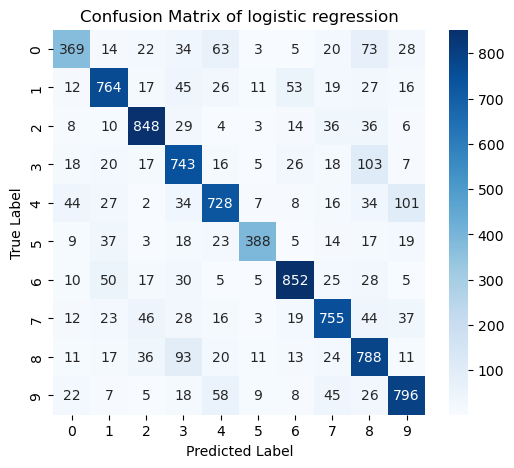

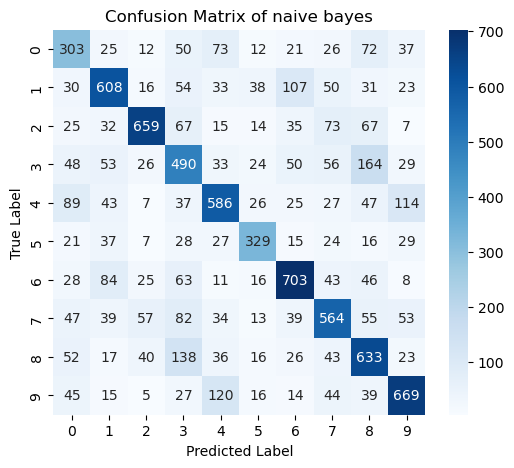

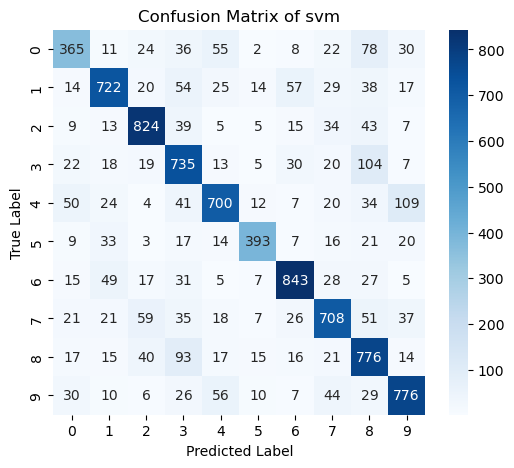

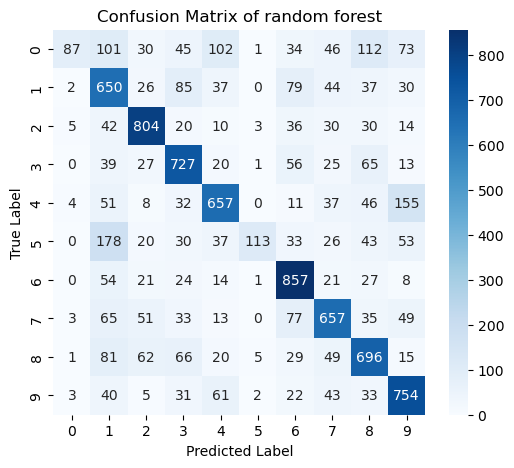

In [108]:
cm1 = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,5))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of logistic regression')
plt.show()

cm2 = confusion_matrix(y_test2, y_pred_nb)
plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of naive bayes')
plt.show()

cm3 = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,5))
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of svm')
plt.show()

cm4 = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm4, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of random forest')
plt.show()

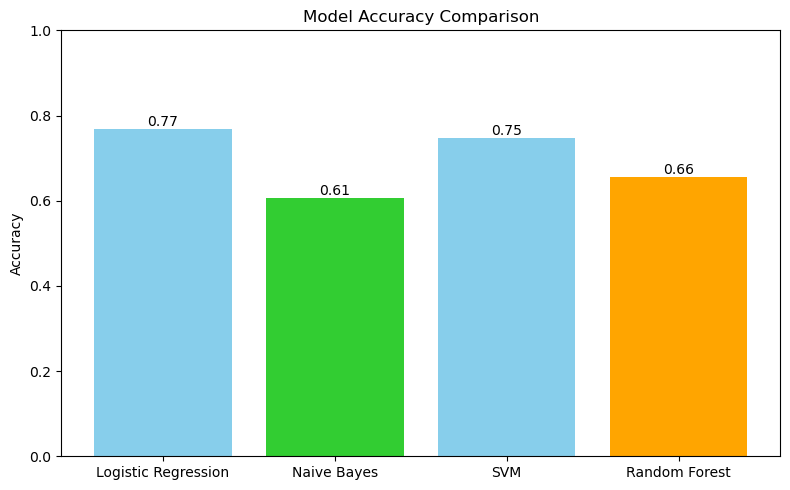

In [85]:
models = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest']
accuracies = [a1,a2,a3,a4]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['skyblue', 'limegreen', 'skyblue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.bar_label(bars, fmt='%.2f')
plt.tight_layout()
plt.show()

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score


In [106]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model1_lr, x, y, cv=5, scoring='f1_macro')
print("logistic regression Average F1 (5-fold CV):", scores.mean())

scores = cross_val_score(model2_nb, x, y, cv=5, scoring='f1_macro')
print("naive bayes Average F1 (5-fold CV):", scores.mean())

scores = cross_val_score(model3_svm, x, y, cv=5, scoring='f1_macro')
print("svm Average F1 (5-fold CV):", scores.mean())

scores = cross_val_score(model4_rf, x, y, cv=5, scoring='f1_macro')
print("rf Average F1 (5-fold CV):", scores.mean())

logistic regression Average F1 (5-fold CV): 0.7939854179859738
naive bayes Average F1 (5-fold CV): 0.7184642386034533
svm Average F1 (5-fold CV): 0.8005215787190852
rf Average F1 (5-fold CV): 0.5963819060618445


Conclusion:
1. Support Vector Machine (SVM) achieved the highest average F1-score (0.801), making it the most balanced model for this task.

2. Logistic Regression showed competitive performance in both accuracy (0.768) and F1-score (0.794), indicating its suitability for this classification task.

3. Naive Bayes, while being a lightweight and interpretable model, performed moderately.

4. Random Forest performed relatively poorly compared to the other models, possibly due to high feature dimensionality and text-based nature of the data.

5. SVM not only had the highest F1-score but also showed more balanced classification across categories in its confusion matrix.

6. 

Based on the evaluation metrics, Support Vector Machine (SVM) is the best-performing model for news article classification in this project. It demonstrates a strong ability to generalize across different categories with a high F1-score, which is crucial for multi-class text classification tasks.

Result based on the confuation matrix of support vector machine:
Strong performing classes:
1. Class 2:
True Positives (TP): 824
Very few misclassifications, mostly into class 3 and 5.
Interpretation: The model is highly confident and accurate in predicting this category.

2. Class 6:
TP: 843
Strong performance, with minimal confusion (only minor misclassifications across class 0, 2, 7).

3. Class 9:
TP: 776
High accuracy with few predictions spilling into classes 2, 3, and 5.
Most confused matrices: 
4. Class 4:
TP = 700, but significant misclassification into class 9 (109 instances).
Indicates class 4 and class 9 may have similar content or linguistic patterns.

Class 5:
TP = 393 — relatively low.
Misclassifications into classes 0, 1, 3, 6, 9 – suggests this category is hard to learn and may need more training data or better features.

Class 0:
TP = 365, but many false positives into classes 1, 2, 3, 6, and 8.
Indicates that the model struggles to clearly separate class 0 from others — possibly due to overlapping vocabulary.

Precision and Recall Pointers:

High Precision and Recall: Classes 2, 6, 9
Moderate: Classes 1, 3, 7, 8
Low Precision/Recall: Classes 0, 4, 5

In [ ]:
Video link: 
https://drive.google.com/file/d/16-kQevIbzQW4czDYtOYcDZfrCjeG_Mpq/view?usp=sharing 